In [ ]:
le.dados <- function(){
  dados <- read.table('sample_data/df_test.csv', header=T, sep = ',')

  return(dados)          }

dados <- le.dados()
head(dados)
#

,Arrest,Hour,Primary.Type_BATTERY,Primary.Type_CRIMINAL.DAMAGE,Primary.Type_THEFT,Domestic_False,Domestic_True
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>
1,False,15,0,0,0,0,1
2,False,3,0,1,0,1,0
3,False,18,0,0,1,1,0
4,False,17,0,1,0,1,0
5,False,13,1,0,0,0,1
6,False,11,0,0,0,0,1


In [ ]:
## Trabalhando com a variável resposta (Arrest)
# tem 6 variaveis
table(dados[,1])


False  True 
43163 10498 

In [ ]:
for (i in 1:nrow(dados)){
	if (dados[i,1]=='False') dados[i,1]<-1 else if (dados[i,1]=='True') dados[i,1]<-0}
table(dados[,1])


    0     1 
10498 43163 

In [ ]:
dadosf<-dados[,c(1,2,3,4,5,6,7)]
str(dadosf)
dadosf$Arrest = as.numeric(as.character(dadosf$Arrest)) # apenas convertendo de char para numeric
#

'data.frame':	53661 obs. of  7 variables:
 $ Arrest                      : num  1 1 1 1 1 1 0 1 1 0 ...
 $ Hour                        : int  15 3 18 17 13 11 13 13 4 10 ...
 $ Primary.Type_BATTERY        : int  0 0 0 0 1 0 0 0 0 0 ...
 $ Primary.Type_CRIMINAL.DAMAGE: int  0 1 0 1 0 0 0 0 1 0 ...
 $ Primary.Type_THEFT          : int  0 0 1 0 0 0 0 0 0 0 ...
 $ Domestic_False              : int  0 1 1 1 0 0 1 1 1 1 ...
 $ Domestic_True               : int  1 0 0 0 1 1 0 0 0 0 ...


In [ ]:
# sequencia inicial para gerar o modelo:

# X_3<-model.matrix(dadosf[,2] ~ factor(dadosf[,2]))[,-1] 
# X_3[1:2,]
Y<-dadosf[,1]
head(Y)
X<-cbind(dadosf[,c(2,3,4,5,6,7)])
colnames(X)<-c("Hour", "Primary.Type_BATTERY","Primary.Type_CRIMINAL.DAMAGE","Primary.Type_THEFT","Domestic_False","Domestic_True")
head(X)
#


,Hour,Primary.Type_BATTERY,Primary.Type_CRIMINAL.DAMAGE,Primary.Type_THEFT,Domestic_False,Domestic_True
,<int>,<int>,<int>,<int>,<int>,<int>
1,15,0,0,0,0,1
2,3,0,1,0,1,0
3,18,0,0,1,1,0
4,17,0,1,0,1,0
5,13,1,0,0,0,1
6,11,0,0,0,0,1


In [ ]:
#### ajustando uma modelo de regressão logística
#
modlin<-glm(Y~.,data=X,family=binomial(link="logit")) #se trocar binomial por gaussian temos o modelo linear de regressão. Se escolhermos poisson temos a regressão Poisson

In [ ]:
#### ajustando uma modelo de regressão logística
#
modlin<-glm(Y~.,data=X) #se trocar binomial por gaussian temos o modelo linear de regressão. Se escolhermos poisson temos a regressão Poisson


In [ ]:
# resíduos ordinários
modlin<-glm(Y~X[,1]+X[,2]+X[,3]+X[,4]+X[,5]+X[,6]-1,family=binomial(link="logit")) # fazendo beta_0=0, no caso dele ser não significativo ou se fizer sentido prático que ele seja igual a zero
#

In [ ]:
#### análise de diagnóstico
#
res.pear<-residuals(modlin,type='pearson')


In [ ]:
# a função modlin$residuals traz os resíduos chamados de working resíduos que é a diferença entre os valores observados e o preditor linear, que não vamos usar aqui
des.res<-residuals(modlin,type='deviance') # desvio residual
#

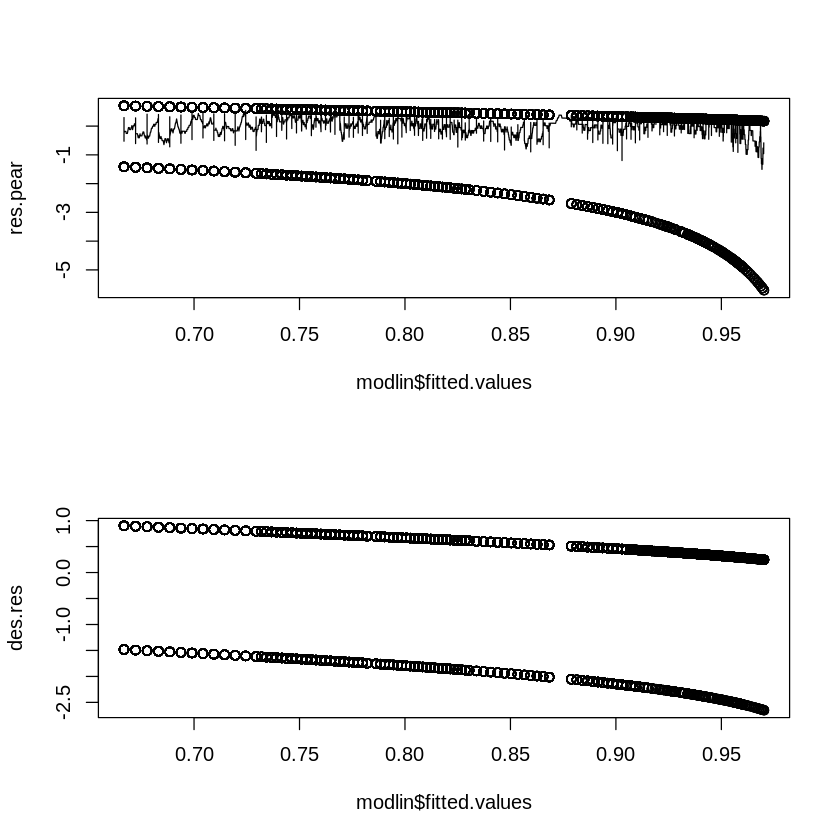

In [ ]:
res_pred<-cbind(modlin$fitted.values,res.pear)
res_pred<-res_pred[order(modlin$fitted.values),]
res.med.mov<-NULL
pred.med.mov<-NULL
cont<-1
jan<-30
for (i in 1:(length(res.pear)-jan)){
	res.med.mov[cont]<-mean(res_pred[i:(i+jan),2])
	pred.med.mov[cont]<-mean(res_pred[i:(i+jan),1])	
	cont<-cont+1}
par(mfrow=c(2,1))
plot(modlin$fitted.values,res.pear)
lines(pred.med.mov,res.med.mov)
plot(modlin$fitted.values,des.res)
#

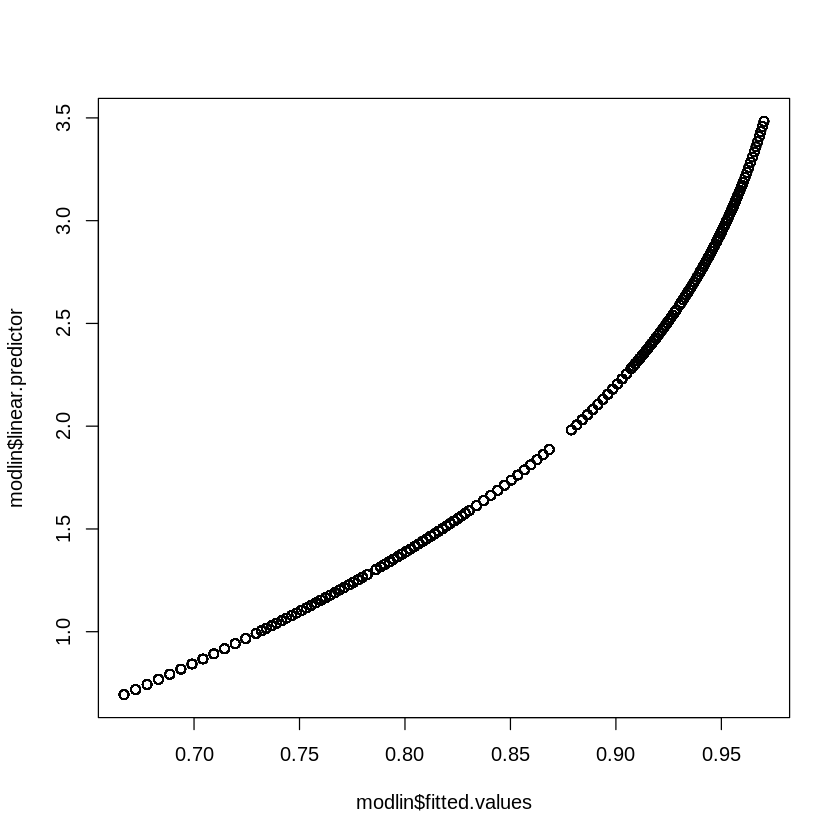

In [ ]:
plot(modlin$fitted.values,modlin$linear.predictor)
#
### taxa correta de classificação
#

[1] 0.666795 0.671795

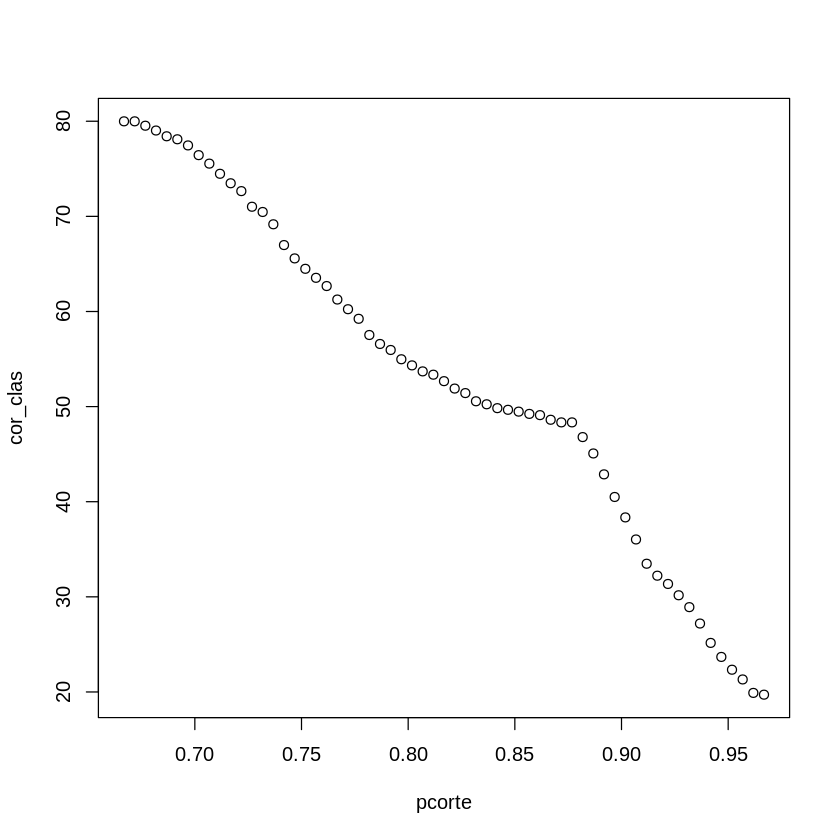

In [ ]:
cor_clas<-NULL
pcorte<-seq(from=min(modlin$fitted.values),to=max(modlin$fitted.values),by=0.005)
for (i in 1:length(pcorte)){
	classif<-ifelse(modlin$fitted.values>pcorte[i],1,0)
	cor_clas[i]<-(table(Y,classif)[1,1]+table(Y,classif)[2,2])/nrow(X)*100}
plot(pcorte,cor_clas)
pcorte[cor_clas==max(cor_clas)]
#

In [ ]:
classif<-ifelse(modlin$fitted.values>pcorte[cor_clas==max(cor_clas)],1,0)
table(classif,Y)
#

Warning message in modlin$fitted.values > pcorte[cor_clas == max(cor_clas)]:
“longer object length is not a multiple of shorter object length”


       Y
classif     0     1
      0   320   559
      1 10178 42604

[1] 0.871795 0.876795

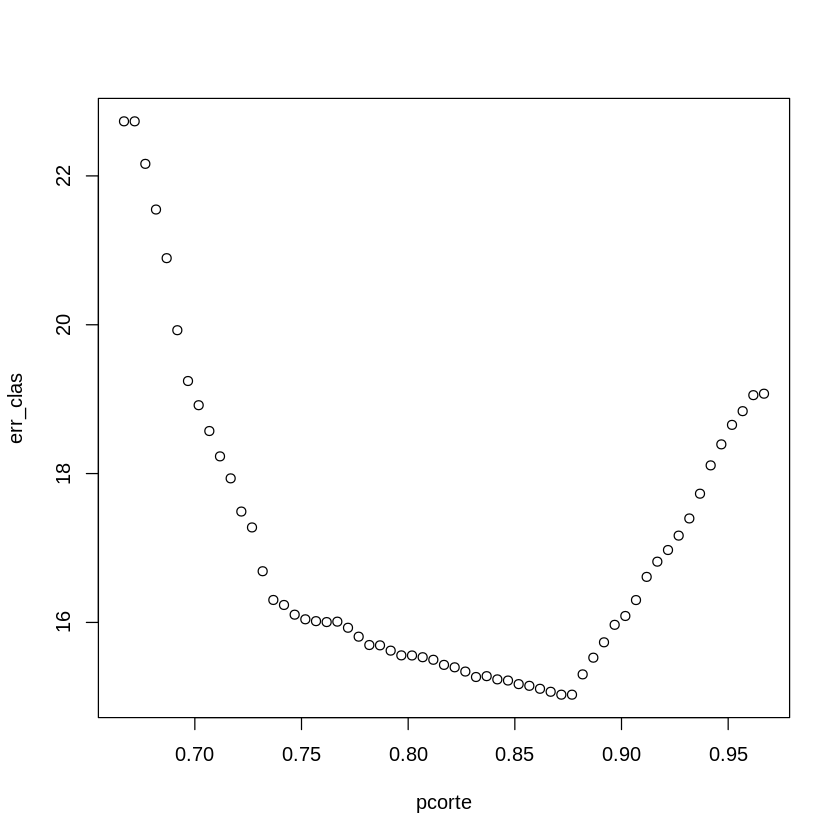

In [ ]:
# dando custo 5 para classificações erradas
err_clas<-NULL
pcorte<-seq(from=min(modlin$fitted.values),to=max(modlin$fitted.values),by=0.005)
for (i in 1:length(pcorte)){
	classif<-ifelse(modlin$fitted.values>pcorte[i],1,0)
	err_clas[i]<-(table(Y,classif)[1,2]+(1/5)*table(Y,classif)[2,1])/((1/5)*sum(Y==0)+sum(Y==1))*100}
plot(pcorte,err_clas)
pcorte[err_clas==min(err_clas)]
#

In [ ]:
classif<-ifelse(modlin$fitted.values>pcorte[err_clas==min(err_clas)],1,0)
table(classif,Y)
#

Warning message in modlin$fitted.values > pcorte[err_clas == min(err_clas)]:
“longer object length is not a multiple of shorter object length”


       Y
classif     0     1
      0  8925 26148
      1  1573 17015

In [ ]:
##### Seleção de variáveis
#
## Usando stepwise por AIC
#
step(modlin, direction="both")
modlin<-glm(Y~X[,2]+X[,3]+X[,4]+X[,5]+X[,6],family=binomial(link="logit"))
summary(modlin)
#

Start:  AIC=49944.39
Y ~ X[, 1] + X[, 2] + X[, 3] + X[, 4] + X[, 5] + X[, 6] - 1

         Df Deviance   AIC
<none>         49932 49944
- X[, 2]  1    50033 50043
- X[, 1]  1    50134 50144
- X[, 6]  1    51527 51537
- X[, 3]  1    51563 51573
- X[, 4]  1    51780 51790
- X[, 5]  1    52183 52193



Call:  glm(formula = Y ~ X[, 1] + X[, 2] + X[, 3] + X[, 4] + X[, 5] + 
    X[, 6] - 1, family = binomial(link = "logit"))

Coefficients:
  X[, 1]    X[, 2]    X[, 3]    X[, 4]    X[, 5]    X[, 6]  
-0.02483   0.31101   1.90772   1.28783   1.26479   1.57558  

Degrees of Freedom: 53661 Total (i.e. Null);  53655 Residual
Null Deviance:	    74390 
Residual Deviance: 49930 	AIC: 49940


Call:
glm(formula = Y ~ X[, 2] + X[, 3] + X[, 4] + X[, 5] + X[, 6], 
    family = binomial(link = "logit"))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5284   0.3382   0.4571   0.8149   0.8149  

Coefficients: (1 not defined because of singularities)
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  1.25365    0.03438  36.469   <2e-16 ***
X[, 2]       0.31292    0.03122  10.022   <2e-16 ***
X[, 3]       1.90085    0.06009  31.635   <2e-16 ***
X[, 4]       1.27422    0.03289  38.741   <2e-16 ***
X[, 5]      -0.32184    0.03439  -9.359   <2e-16 ***
X[, 6]            NA         NA      NA       NA    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 53048  on 53660  degrees of freedom
Residual deviance: 50134  on 53656  degrees of freedom
AIC: 50144

Number of Fisher Scoring iterations: 5


In [ ]:
install.packages("glmnet") 

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘iterators’, ‘foreach’, ‘shape’




7 x 1 sparse Matrix of class "dgCMatrix"
                                        s0
(Intercept)                   1.559228e+00
Hour                         -2.378861e-02
Primary.Type_BATTERY          2.930938e-01
Primary.Type_CRIMINAL.DAMAGE  1.845483e+00
Primary.Type_THEFT            1.256984e+00
Domestic_False               -2.962577e-01
Domestic_True                 7.264425e-13

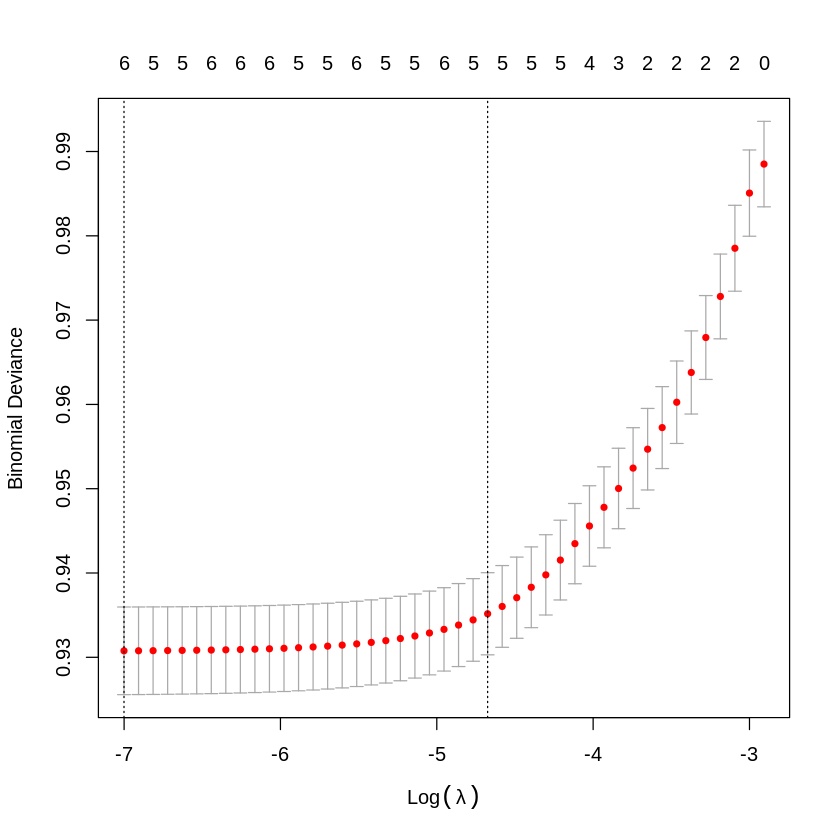

In [ ]:
## Seleção de variáveis via Lasso
#
library(glmnet)
set.seed(100)
matX<-data.matrix(X)
cv.out<-cv.glmnet(matX,Y,alpha=1,nfolds=5,family="binomial") 
plot(cv.out)
bestlam<-cv.out$lambda.min
modlasso<-glmnet(matX,Y,alpha=1,lambda=bestlam,family="binomial")
coef(modlasso)

7 x 1 sparse Matrix of class "dgCMatrix"
                                     s0
(Intercept)                   1.4368921
Hour                         -0.0237059
Primary.Type_BATTERY          0.2801015
Primary.Type_CRIMINAL.DAMAGE  1.7272992
Primary.Type_THEFT            1.2059365
Domestic_False               -0.1615774
Domestic_True                 0.1430677

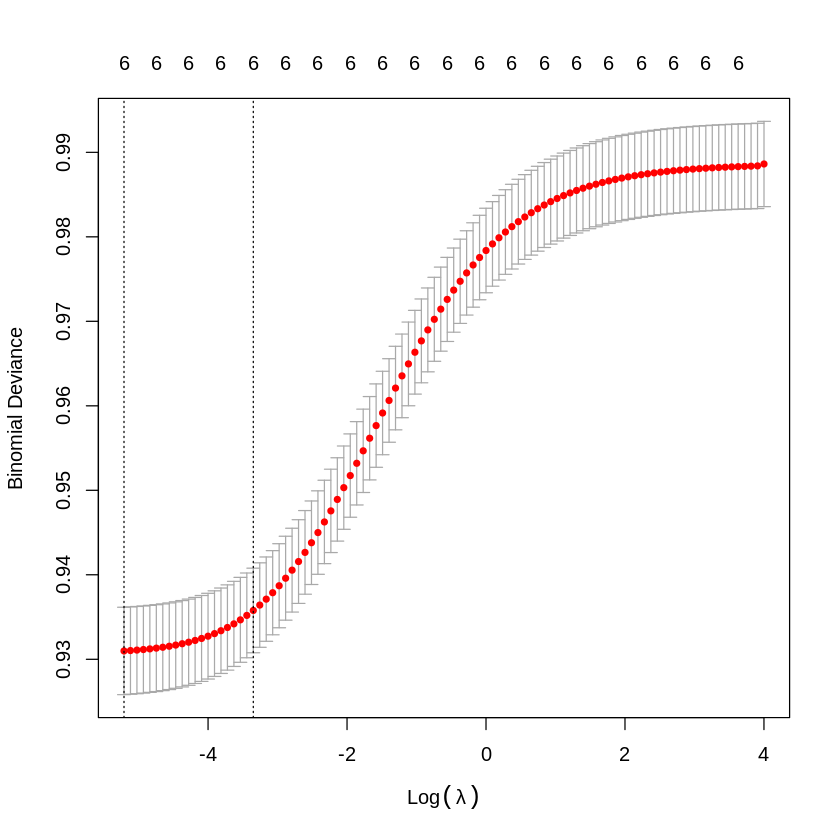

In [ ]:
## Seleção de variáveis via Ridge
#
set.seed(100)
cv.out<-cv.glmnet(matX,Y,alpha=0,nfolds=5,family="binomial") 
plot(cv.out)
bestlam<-cv.out$lambda.min
modridge<-glmnet(matX,Y,alpha=0,lambda=bestlam,family="binomial")
coef(modridge)
#